In [2]:
import seaborn as sns
import pandas as pd
import kneed
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from time import time
import numpy as np


## Experimental parameters

In [22]:
# biasDegree = 
# classImbalanceDegree = 
sizeOfLabeledSet = 0.025
auxiliary_noise=30


# Import data

In [ ]:
df_train=pd.read_csv('train_0.csv')
df_test=pd.read_csv('test_0.csv')

## Train classifier on whole dataset

### Prep and split data

In [88]:
y=fold_train.y_50
#additional to dropping the endpoints we also drop the run and event numbers, because those aren't predictors
X=fold_train.drop(columns=['M_noise','M','Run','Event','y_50','y_25','y_10','index_og','index_reduced'])

### Train RF classifier

In [89]:
rf = RandomForestClassifier()
t0 = time()
rf.fit(X, y)
print ('training time: ', round(time()-t0, 3), 's')

training time:  3.954 s


In [90]:
t1=time()
pred_rf = rf.predict(X)
print ('predicting time: ', round(time()-t1, 3), 's')
print("Accuracy:",metrics.accuracy_score(y, pred_rf))

predicting time:  0.259 s
Accuracy: 1.0


### Get probabilities

In [91]:
pred = rf.predict(X)
prob = rf.predict_proba(X)

### Get prob files

In [92]:
predictions_noise_12_100 = pd.DataFrame(X)
predictions_noise_12_100['pred'] = pred
predictions_noise_12_100['prob1'] = prob[:,1]
predictions_noise_12_100.to_csv('predictions_noise_12_100.csv')

## Bin data

In [94]:
pd.qcut(predictions_noise_12_100['prob1'], q=7)

0        (-0.001, 0.03]
1        (-0.001, 0.03]
2        (-0.001, 0.03]
3           (0.98, 1.0]
4          (0.03, 0.07]
              ...      
17995      (0.16, 0.83]
17996       (0.98, 1.0]
17997      (0.94, 0.98]
17998      (0.83, 0.94]
17999       (0.98, 1.0]
Name: prob1, Length: 18000, dtype: category
Categories (7, interval[float64]): [(-0.001, 0.03] < (0.03, 0.07] < (0.07, 0.16] < (0.16, 0.83] < (0.83, 0.94] < (0.94, 0.98] < (0.98, 1.0]]

In [95]:
def bin_data (data, number_of_bins):
    dict_bins = pd.Series.to_dict(pd.qcut(data, q=number_of_bins, labels=False))
    return dict_bins

In [96]:
predictions_noise_12_100_binned = bin_data(predictions_noise_12_100['prob1'], 7)

## Calculate bin distribution

In [ ]:
# Might want to move this to a separate file

In [79]:
def get_bin_distribution(a,k):
    distribution = []
    for x in range (1,8):
        f_x = a*(x-4)**2+k
        distribution.append(f_x)    
    print (sum(distribution))
    for i in range (7):
        distribution[i]=distribution[i]/sum(distribution)        
    return distribution

# Add auxiliary variable bias

In [98]:
# Add columns voor auxiliary variables
fold_train['s1']=fold_train['pz1']
fold_train['s2']=fold_train['pz2']
# add noise to s1 and s2
#add noise to s
for i in range(fold_train.shape[0]):
    fold_train['s2'].iat[i]=fold_train['s2'].iloc[i]+np.random.normal(0,auxiliary_noise)

In [99]:
fold_train['in_sample']=(fold_train['s1'] < 30) & (fold_train['s1']>-30) & (fold_train['s2'] < 30) & (fold_train['s2']>-30)

# Add uncertainty bias

## Pick sample

In [105]:
import random
import math

#this function returns the dataframe with a new column that indicates whether an instance is in the sample or not.
def get_sample(sample_size, distribution, data_binned, df):
    
    #ugly for now, a new dataframe that has a column for whether an instance is in the sample or not
    df_sampled = fold_train
    in_sample = [0]* df_sampled.shape[0]
    
    indices=[]
    for bin in range (7):
        pool = []
        for i in range (len(data_binned)):
            if data_binned[i]==bin:
                pool.append(i)
        indices.extend(random.sample(pool , math.ceil(distribution[bin]*sample_size)))
        print(len(indices))
    sample = []
    for i in indices:
        sample.append(fold_train.iloc[[i]])
        in_sample[i]=1
    df_sampled['in_sample']=in_sample     
    #return pd.concat(sample)
    return df_sampled

In [83]:
i=0
for key, value in predictions_noise_12_100_binned.items():
    print (key,',',value)
    i+=1
    if i>10:
        break

1 , 0
2 , 0
3 , 0
4 , 6
5 , 2
6 , 1
7 , 4
8 , 1
9 , 2
12 , 1
13 , 1


In [26]:
distribution_004_000 = get_bin_distribution(1/28,0)

1.0


In [113]:
fold_train=get_sample(300, distribution_004_000, predictions_noise_12_100_binned, fold_train)

97
140
151
151
162
205
302


In [114]:
fold_train.to_csv('train_index_0.csv')

## Visualize sample

In [107]:
fold_train[fold_train['in_sample']==1].shape[0]

302

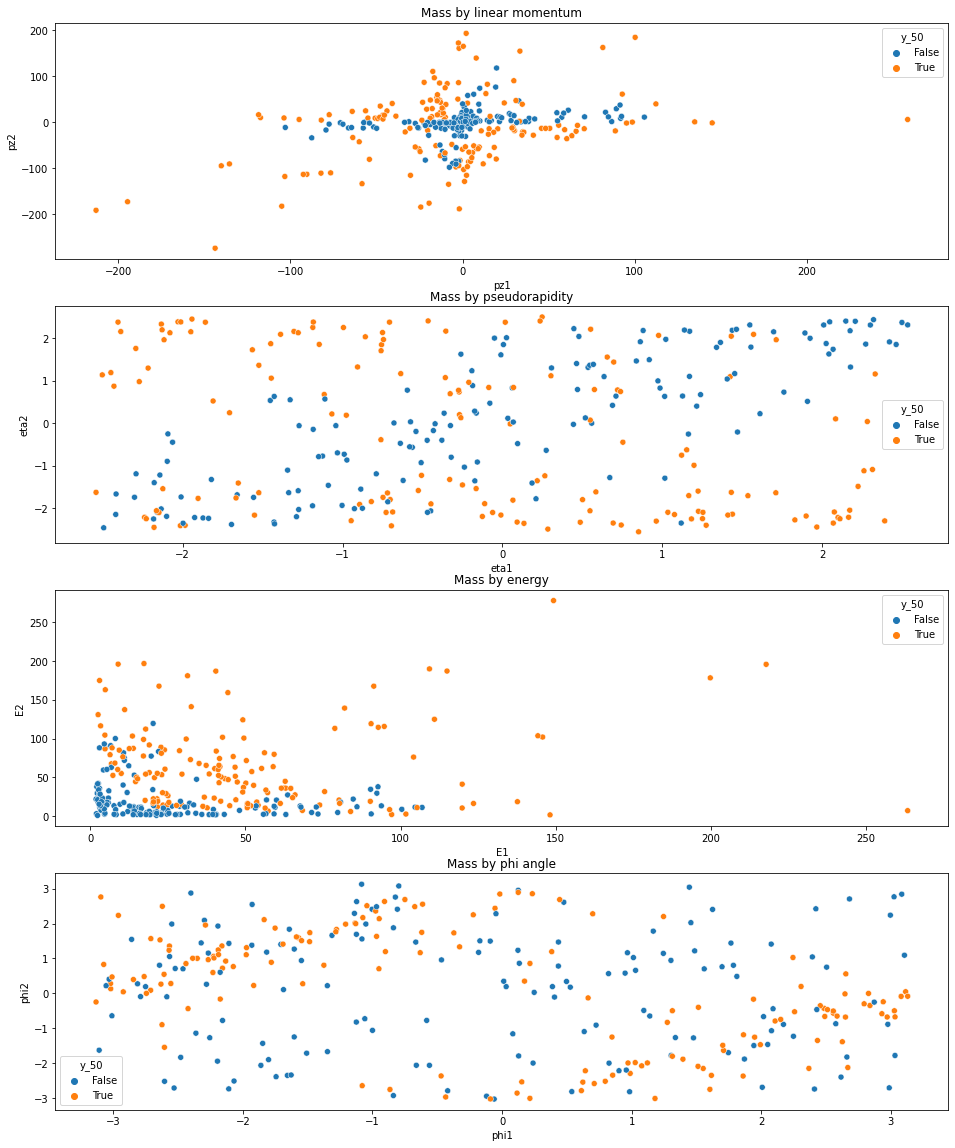

In [108]:
fig,ax = plt.subplots(nrows=4,ncols=1,figsize=(16,20))

sns.scatterplot(ax= ax[0],data=fold_train[fold_train['in_sample']==1], x='pz1', y='pz2', hue='y_50')
ax[0].set_title('Mass by linear momentum')
sns.scatterplot(ax= ax[1],data=fold_train[fold_train['in_sample']==1], x='eta1', y='eta2', hue='y_50')
ax[1].set_title('Mass by pseudorapidity')
sns.scatterplot(ax= ax[2],data=fold_train[fold_train['in_sample']==1], x='E1', y='E2', hue='y_50')
ax[2].set_title('Mass by energy')
sns.scatterplot(ax= ax[3],data=fold_train[fold_train['in_sample']==1], x='phi1', y='phi2', hue='y_50')
ax[3].set_title('Mass by phi angle')

plt.show()